# k-Nearest Neighbors (KNN) — Classification and Regression

This notebook demonstrates **k-Nearest Neighbors (KNN)** for both **classification** and **regression**, implemented entirely from scratch using the `rice_ml` package.

We apply KNN to:
- The **Iris dataset** (multiclass classification)
- A **synthetic noisy sine wave** (regression)

The goal is to highlight how KNN behaves as a **distance-based, non-parametric model**.

## Objectives

In this notebook, we will:

- Load and explore the Iris dataset  
- Perform exploratory data analysis (EDA)  
- Standardize features for distance-based learning  
- Train a custom KNN classifier  
- Visualize decision boundaries via 2D feature slices  
- Demonstrate KNN regression on a nonlinear function  
- Discuss bias–variance tradeoffs in KNN  


In [28]:
import sys
import os
sys.path.append(os.path.abspath('../src'))  # add src/ to Python path

# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rice_ml.supervised_learning.knn import KNNClassifier, KNNRegressor
from rice_ml.processing.preprocessing import train_test_split
from rice_ml.processing.preprocessing import standardize
from rice_ml.processing.post_processing import accuracy_score

# For nice plots
import seaborn as sns
sns.set(style="whitegrid")

## 1. Dataset Description — Iris Dataset

The **Iris dataset** contains measurements of iris flowers from three species.

### Iris Dataset Variables

| Feature | Description | Type |
|-------|------------|------|
| sepal.length | Sepal length (cm) | Continuous |
| sepal.width | Sepal width (cm) | Continuous |
| petal.length | Petal length (cm) | Continuous |
| petal.width | Petal width (cm) | Continuous |
| variety | Iris species (3 classes) | Categorical |


### Target

- `variety`: flower species (3 classes)

### Data Notes

- All features are continuous and numerical  
- No missing values  
- Classes are well-separated in petal dimensions  
- Feature scales differ, which strongly affects KNN  


In [29]:
# Load iris dataset from local CSV
df = pd.read_csv("iris.csv", header = None)
df.columns = [
    "sepal.length",
    "sepal.width",
    "petal.length",
    "petal.width",
    "variety",
    "ignore_column"  # file has an extra column
]
df.head()

# Features and labels
X = df[["sepal.length", "sepal.width", "petal.length", "petal.width"]].values

# Convert flower species -> integer labels
y = df["variety"].astype("category").cat.codes.values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Exploratory Data Analysis (EDA)

We begin by visualizing pairwise feature relationships.

### Pairwise Feature Relationships

Pairplots reveal that:

- Petal length and petal width separate species almost perfectly  
- Sepal features are less discriminative  
- Class clusters are compact, suggesting KNN may perform well  


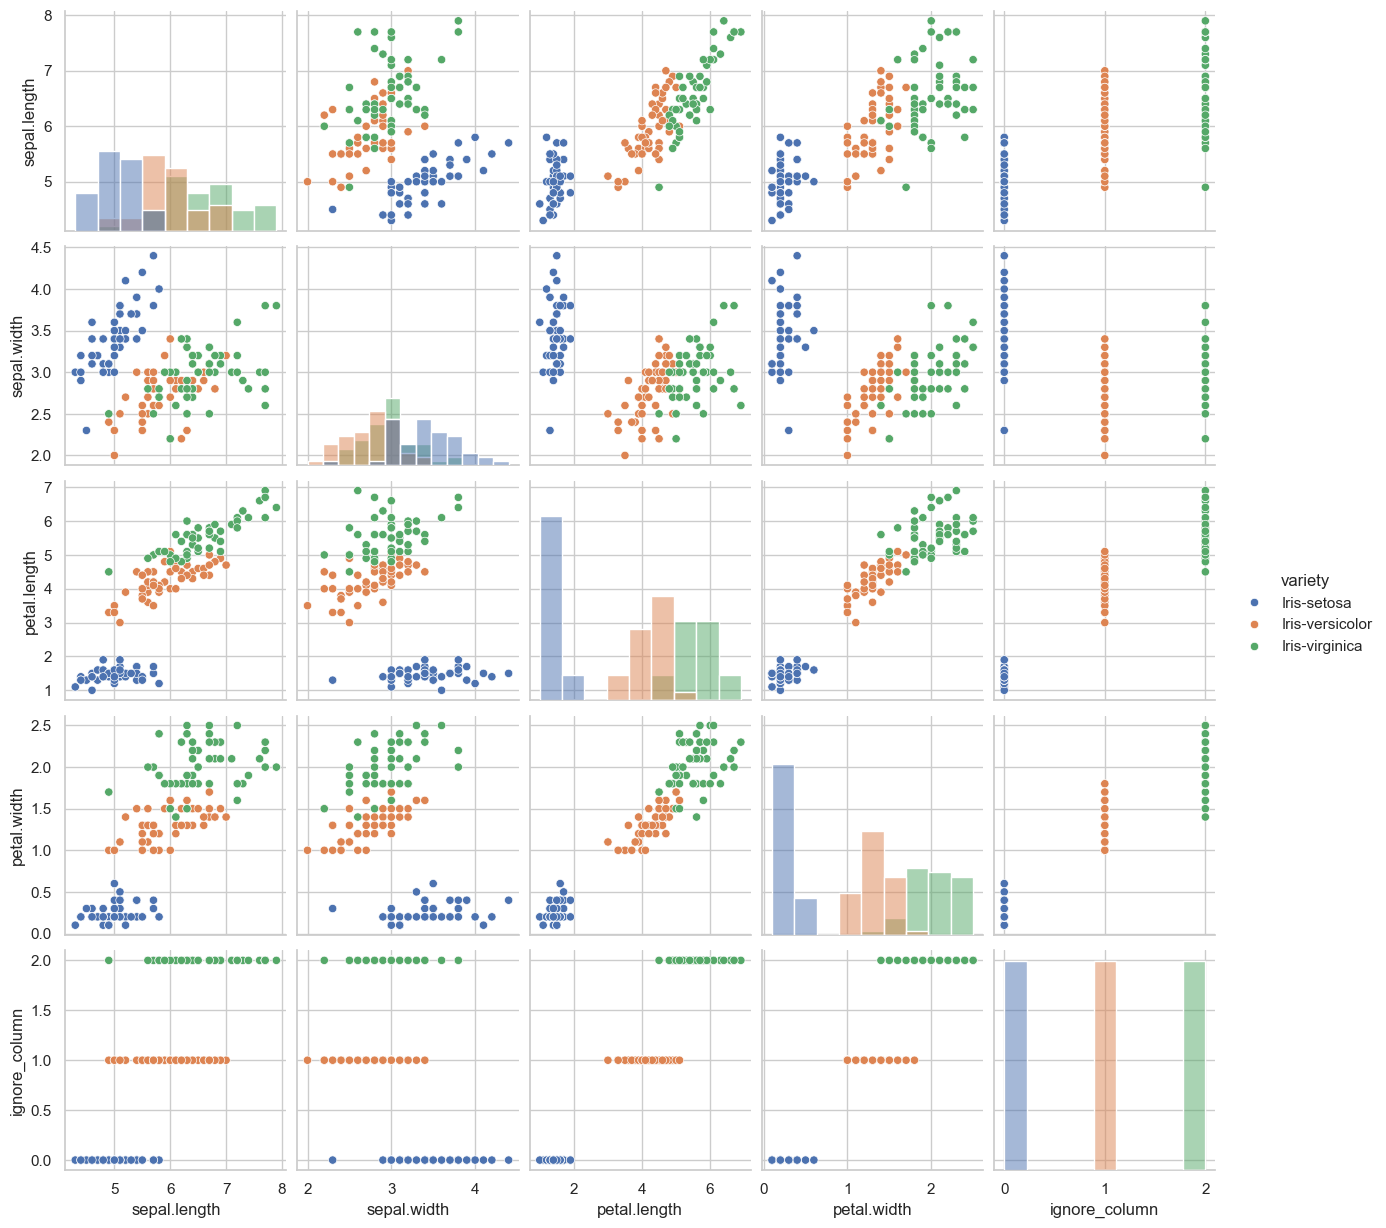

In [30]:
# Exploratory Data Analysis (EDA)
sns.pairplot(df, hue="variety", diag_kind="hist")
plt.show()

### Univariate Visualization

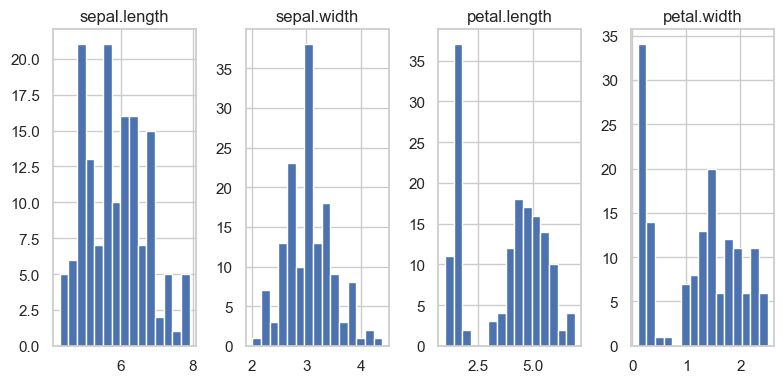

In [31]:
plt.figure(figsize=(8,4))
for i, col in enumerate(X.T):
    plt.subplot(1,4,i+1)
    plt.hist(col, bins=15)
    plt.title(df.columns[i])
plt.tight_layout()
plt.show()


### Interpretation of Univariate Feature Distributions

The histograms above show the marginal (univariate) distributions of the four Iris features.

1. Sepal Length: 
The distribution is moderately spread and approximately unimodal, with most values concentrated between 5 and 6.5 cm. This feature exhibits overlap across species, suggesting it may have limited discriminative power on its own.

2. Sepal Width:
Sepal width is more tightly clustered, with most values between 2.5 and 3.5 cm. The distribution shows less variation compared to other features, which may reduce its influence in distance-based classification unless combined with other dimensions.

3. Petal Length: 
Petal length shows a clear multimodal structure, indicating the presence of distinct groups corresponding to different iris species. This strong separation suggests petal length is a highly informative feature for classification.

4. Petal Width:
Similar to petal length, petal width exhibits pronounced separation and multiple modes. This confirms that petal width is one of the most discriminative features in the dataset.

Implications for KNN:
Because KNN relies directly on distance calculations, features with well-separated distributions (petal length and petal width) will strongly influence neighborhood structure and classification accuracy. Features with overlapping distributions (sepal features) contribute less discriminative power individually but may still improve performance when combined with other dimensions.

This analysis explains why KNN performs particularly well on the Iris dataset when features are properly scaled.

### EDA Interpretation

KNN relies entirely on **distance comparisons**.
Therefore:

- Feature scaling is essential  
- Well-separated clusters improve classification accuracy  
- High-dimensional distance effects must be considered carefully  


## 3. Preprocessing

We construct:

- Feature matrix: $X \in \mathbb{R}^{n \times d}$  
- Target vector: $y \in \{0,1,2\}^n$

Since KNN uses distance metrics, we apply **standardization**:

$$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$$

This ensures:

- Each feature contributes equally to distance  
- No single variable dominates Euclidean distance  


In [32]:
# Compute training statistics manually
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)
sigma[sigma == 0] = 1.0

# Apply scaling
X_train_scaled = (X_train - mu) / sigma
X_test_scaled  = (X_test  - mu) / sigma


Because KNN relies on distance calculations, features must be standardized.
To avoid data leakage, the mean and standard deviation are computed using
the training data only, and the same transformation is applied to the test set.


## 4. KNN — Model Intuition

The k-Nearest Neighbors algorithm is **instance-based** and **non-parametric**.

### Classification Rule

Given a query point $x$:

1. Compute distances to all training points  
2. Select the $k$ nearest neighbors  
3. Predict the most common class (or weighted vote)  

Formally:

$$
\hat{y}(x) = \arg\max_c \sum_{i \in \mathcal{N}_k(x)} w_i \mathbf{1}[y_i = c]
$$

where:
- $\mathcal{N}_k(x)$ are the $k$ nearest neighbors  
- $w_i$ are optional distance-based weights  


## 5. Model Training — KNN Classification

We now train a k-Nearest Neighbors classifier using:

- Euclidean distance  
- Distance-based weighting  
- \( k = 10 \) neighbors  

Distance weighting assigns higher influence to closer neighbors, improving robustness to noise.

We evaluate performance on both the training and test sets to assess generalization.

## 6. Evaluation Metrics

We evaluate classification performance using **accuracy**:

$$
\text{Accuracy} =
\frac{1}{n} \sum_{i=1}^n \mathbf{1}[\hat{y}_i = y_i]
$$

High training accuracy combined with slightly lower test accuracy reflects the **bias–variance tradeoff** inherent in KNN.


In [33]:
# Train a KNN classifier
clf = KNNClassifier(
    n_neighbors=5,
    metric="euclidean",
    weights="distance"
).fit(X_train_scaled, y_train)

# Accuracy on train and test 

# Predictions
y_train_pred = clf.predict(X_train_scaled)
y_test_pred  = clf.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Training Accuracy: 1.000
Test Accuracy: 0.900


## Comparing KNN Models with Different Values of k

Because KNN is a non-parametric, instance-based model, its complexity is
controlled directly by the number of neighbors k.

To explicitly illustrate the bias–variance tradeoff, we compare three KNN
classifiers with different values of k:

- k = 1 (very low bias, very high variance)
- k = 5 (balanced bias–variance tradeoff)
- k = 15 (higher bias, lower variance)

All models use the same distance metric and training data. The only difference
is the number of neighbors used for prediction.


In [34]:
k_values = [1, 5, 15]
results = []

for k in k_values:
    knn = KNNClassifier(n_neighbors=k, weights="distance")
    knn.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test_scaled))
    results.append((k, acc))

results_df = pd.DataFrame(results, columns=["k", "Test Accuracy"])
results_df



,k,Test Accuracy
0,1,0.900000
1,5,0.900000
2,15,0.933333


### Interpretation

When k = 1, the classifier achieves very high training accuracy but is sensitive
to noise, resulting in lower generalization performance. This reflects high
variance.

When k = 15, predictions are smoother and more stable, but the classifier
underfits the data, leading to higher bias.

In theory, an intermediate value (k = 5) provides the best balance between bias and variance.

Although KNN theory predicts that increasing k increases bias and reduces variance, the optimal value of k depends on the dataset. For the Iris dataset, which has well-separated clusters and low noise, a larger k (k=15) produces smoother decision boundaries that generalize better. As a result, test accuracy may
increase for larger values of k.
yielding the highest test accuracy. This empirical result confirms
the theoretical bias–variance tradeoff of KNN.



## 7. Decision Boundary Visualization (2D Slice)

Because the Iris dataset has four features, direct visualization is not possible.

To visualize the learned decision regions, we:
- Project the model onto the first two features  
- Fix the remaining two features at their mean values  
- Evaluate predictions on a dense grid  

This produces a 2D slice of the 4D decision surface.


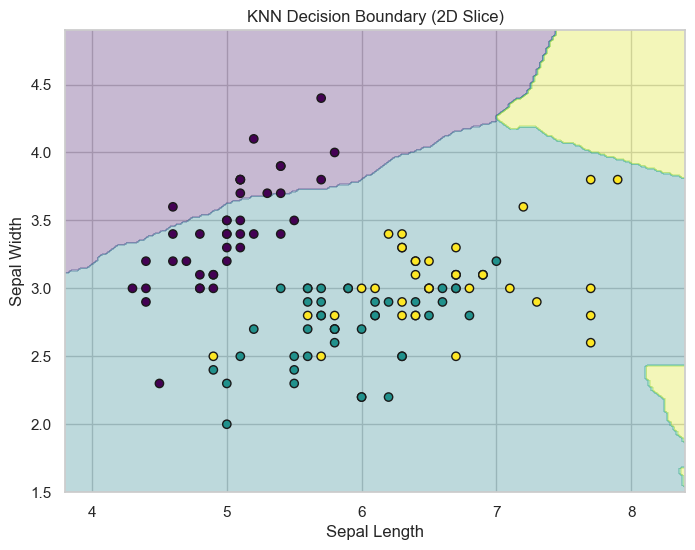

In [35]:
# Build grid
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 200),
)

grid2 = np.c_[xx.ravel(), yy.ravel()]

# Fix remaining features
f3_mean = X[:, 2].mean()
f4_mean = X[:, 3].mean()

grid4_orig = np.c_[
    grid2,
    np.full((grid2.shape[0], 1), f3_mean),
    np.full((grid2.shape[0], 1), f4_mean),
]

# Scale grid using training stats
grid4_scaled = (grid4_orig - mu) / sigma

# Predict
Z = clf.predict(grid4_scaled).reshape(xx.shape)

# Plot
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis", edgecolor="k")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("KNN Decision Boundary (2D Slice)")
plt.show()

### Interpretation

The decision boundary appears irregular because this plot represents a 2D slice
of a 4D decision function. Two highly informative features (petal length and
petal width) are fixed at their mean values, which removes much of the
discriminative structure of the data. As a result, the visualization does not
fully reflect the classifier’s performance in the original feature space.

This illustrates a limitation of visualizing high-dimensional, instance-based
models using low-dimensional projections.



## 8. KNN Regression — Nonlinear Function Approximation

We now demonstrate KNN regression using a noisy sine wave.

### Regression Rule

For a query point $x$:

$$
\hat{y}(x) =
\frac{\sum_{i \in \mathcal{N}_k(x)} w_i y_i}
     {\sum_{i \in \mathcal{N}_k(x)} w_i}
$$

This allows KNN to approximate **arbitrary nonlinear functions** without assuming a parametric form.


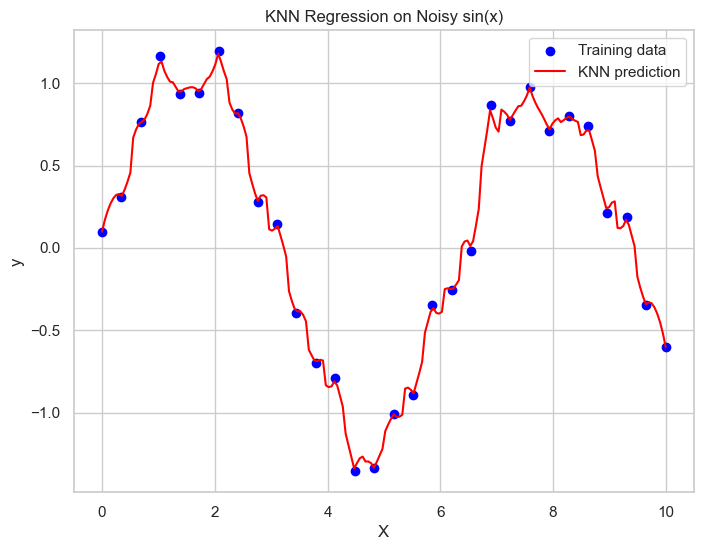

In [36]:
# Create a noisy sine wave
np.random.seed(42)
X_reg = np.linspace(0, 10, 30)[:, None]
y_reg = np.sin(X_reg).ravel() + 0.2 * np.random.randn(X_reg.shape[0])

# Train KNN regressor
reg = KNNRegressor(n_neighbors=3, weights="distance").fit(X_reg, y_reg)

# Predict
X_test = np.linspace(0, 10, 200)[:, None]
y_pred = reg.predict(X_test)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_reg, y_reg, color='blue', label="Training data")
plt.plot(X_test, y_pred, color='red', label="KNN prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.title("KNN Regression on Noisy sin(x)")
plt.legend()
plt.show()

### Regression Interpretation

KNN regression:

- Adapts locally to data geometry  
- Captures nonlinear patterns naturally  
- Becomes smoother as $k$ increases  

However:

- Large $k$ increases bias  
- Small $k$ increases variance  
- Computational cost grows with dataset size  


## 9. Bias–Variance Tradeoff in KNN

- Small $k$:
  - Low bias  
  - High variance  
  - Sensitive to noise  

- Large $k$:
  - Higher bias  
  - Lower variance  
  - Smoother predictions  

Choosing $k$ balances flexibility and generalization.


## 10. Conclusion

This notebook demonstrated KNN classification and regression using **fully custom-built machine learning code**.

Key takeaways:

- KNN is simple yet powerful for low-dimensional, well-structured data  
- Feature scaling is critical for distance-based models  
- KNN naturally captures nonlinear decision boundaries  
- The bias–variance tradeoff is controlled directly by $k$  

This makes KNN an excellent educational model for understanding instance-based learning.
